In [5]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal,beta,dirichlet, norm
from math import log
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)
from scipy.special import gamma
import ternary


np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [6]:
sz = 100
x1 = norm.rvs(-2,1,size=sz)
x2 = norm.rvs(2,1,size=sz)
x3 = norm.rvs(6,1,size=sz)
x = np.hstack((x1,x2,x3))

(array([1.000, 2.000, 5.000, 11.000, 27.000, 29.000, 21.000, 6.000, 13.000,
        23.000, 24.000, 26.000, 9.000, 7.000, 8.000, 27.000, 33.000,
        17.000, 9.000, 2.000]),
 array([-5.564, -4.847, -4.131, -3.414, -2.698, -1.982, -1.265, -0.549,
        0.167, 0.884, 1.600, 2.317, 3.033, 3.749, 4.466, 5.182, 5.898,
        6.615, 7.331, 8.047, 8.764]),
 <BarContainer object of 20 artists>)

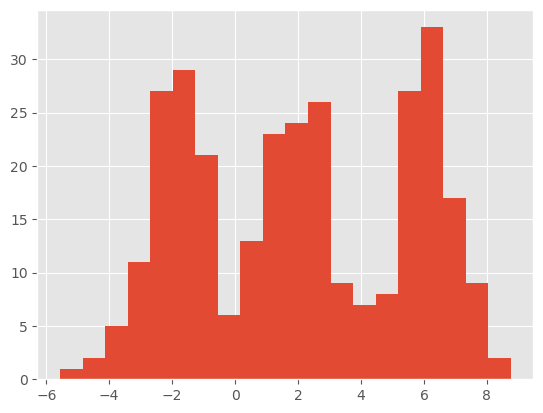

In [7]:
plt.hist(x,bins=20)

In [8]:
c_id = np.zeros(x.shape)
clusters,cluster_counts = np.unique(c_id,return_counts=True)
n_cluster = len(clusters)

sigma0 = 1
mu0 = 0

# sigma_cluster = np.array([sigma0])
# mu_cluster = np.array([mu0])

sigma_y = 1
tau_y = 1/(sigma_y**2)
ite = 3
alpha = 10

In [9]:
# rand_x = p0.rvs(size=2*sz)

# rand_x_prob = dirichlet.pdf(rand_x,size=2*sz)

# pred_x = norm.rvs(rand_x,sigma0,size=2*sz) * rand_x_prob

In [10]:
for it in range(ite):
    for i in range(sz*2):
        print("Before calculating-------------------------------------------")
        print(f"cluster counts is:{cluster_counts}")
        print(f"number of cluster is {n_cluster}")
        assign_id = int(c_id[i])
        cluster_counts[assign_id] -= 1
        # print(f"cluster counts after minus 1 is:{cluster_counts}")
        if cluster_counts[assign_id] == 0:
            cluster_counts[assign_id] = cluster_counts[-1]
            # print(f"cluster counts after switching the last cluster element:{cluster_counts}")
            c_id[np.where(c_id==n_cluster-1)[0]] = assign_id
            cluster_counts = np.delete(cluster_counts, n_cluster-1) 
            # print(f"cluster counts after deleting the last cluster:{cluster_counts}")
            n_cluster -= 1
        c_id[i] = -1

        # print(f"This is the {it} iteration, and the {i}th element. The {assign_id}th element in the c_id")
        # print(f"After calculating-------------------------")
        # print(f"cluster counts is:{cluster_counts}")
        # print(f"number of cluster is {n_cluster}")

        logp = np.zeros((n_cluster+1))
        for j in range(n_cluster):

            idx = np.where(c_id == j)[0] # element indices within clusters[j]
            y_average = np.mean(x[idx])
            prior_tau_j = 1/(sigma0**2)
            mu_j = (y_average*cluster_counts[j]* tau_y + mu0 * prior_tau_j )/ (cluster_counts[j]* tau_y + prior_tau_j )
            sigma_j = np.sqrt(1/(cluster_counts[j]* tau_y + prior_tau_j ) + sigma_y**2)
            
            logp[j] = np.log(cluster_counts[j]/(sz*2-1+alpha)) + norm.logpdf(x[i],mu_j,sigma_j)
        new_cluster_mu = mu0
        new_cluster_sigma = np.sqrt(sigma0**2+sigma_y**2)
        
        logp[-1] = np.log(alpha/(sz*2-1+alpha)) + norm.logpdf(x[i],new_cluster_mu,new_cluster_sigma)
        print(f"logp is:{logp}")
        logp_max = np.max(logp)
        logp = logp - logp_max
        p = np.exp(logp)
        p = p/np.sum(p)
        print(f"p is:{p}")        
        new_c = np.random.choice(np.arange(n_cluster+1),p=p)
        # print(f"new class is : {new_c}")
        if new_c == n_cluster:
            # clusters = np.append(clusters,new_c)
            n_cluster += 1
            cluster_counts = np.append(cluster_counts,1)
        else:
            cluster_counts[new_c] += 1
        c_id[i] = new_c



Before calculating-------------------------------------------
cluster counts is:[300.000]
number of cluster is 1
logp is:[-6.946 -4.889]
p is:[0.113 0.887]
Before calculating-------------------------------------------
cluster counts is:[299.000 1.000]
number of cluster is 2
logp is:[-14.348 -8.427 -6.851]
p is:[0.000 0.171 0.828]
Before calculating-------------------------------------------
cluster counts is:[298.000 1.000 1.000]
number of cluster is 3
logp is:[-4.053 -6.477 -6.816 -4.386]
p is:[0.535 0.047 0.034 0.384]
Before calculating-------------------------------------------
cluster counts is:[297.000 1.000 2.000]
number of cluster is 3
logp is:[-10.238 -7.263 -6.133 -5.642]
p is:[0.006 0.109 0.336 0.549]
Before calculating-------------------------------------------
cluster counts is:[296.000 1.000 2.000 1.000]
number of cluster is 4
logp is:[-12.193 -7.740 -6.520 -7.280 -6.156]
p is:[0.001 0.092 0.312 0.146 0.449]
Before calculating-------------------------------------------
clu

In [11]:
mu_j = np.zeros((n_cluster))
for j in range(n_cluster):

    idx = np.where(c_id == j)[0] # element indices within clusters[j]
    y_average = np.mean(x[idx])
    prior_tau_j = 1/(sigma0**2)
    mu_j[j] = (y_average*cluster_counts[j]* tau_y + mu0 * prior_tau_j )/ (cluster_counts[j]* tau_y + prior_tau_j )
    


In [12]:
print(mu_j)
print(cluster_counts)

[6.013 -1.119 -1.659 -2.163 -1.360 -2.520 -2.201 1.814 1.296 0.988 0.725
 0.939 0.423 0.737 -0.673 -0.938 -1.756 1.155 -0.662 0.275 1.897 2.073
 1.040 0.049 2.252 -0.108 -1.172 1.076 -1.200 0.964]
[104.000 8.000 24.000 30.000 1.000 2.000 17.000 7.000 6.000 3.000 1.000
 1.000 2.000 9.000 8.000 1.000 5.000 2.000 1.000 1.000 12.000 25.000 3.000
 2.000 19.000 2.000 1.000 1.000 1.000 1.000]


<BarContainer object of 30 artists>

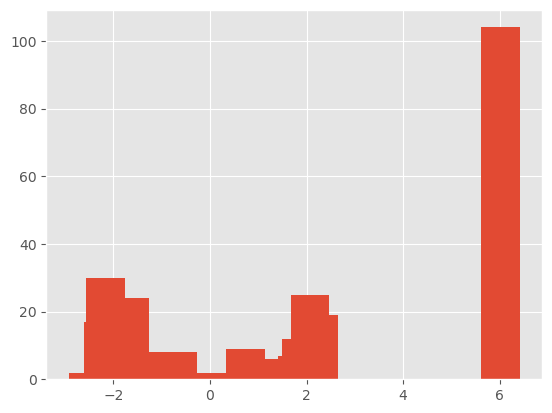

In [13]:
plt.bar(mu_j,cluster_counts)

In [14]:
# start = 0
# scale = 10
# for i in range(start, scale + (1 - start)):
#     for j in range(start, scale + (1 - start) - i):
#         k = scale - i - j
#         print(i, j, k)

In [15]:
# # showcasing Dirichlet distribution
# def f(x):
#     return x[0]**(a1-1) * x[1]**(a2-1) * x[2]**(a3-1)/beta

# scale = 60
# fig, tax = ternary.figure(scale=scale)
# tax.heatmapf(f,scale=scale)

In [16]:
# def shannon_entropy(p):
#     """Computes the Shannon Entropy at a distribution in the simplex."""
#     s = 0.
#     for i in range(len(p)):
#         try:
#             s += p[i] * log(p[i])
#         except ValueError:
#             continue
#     return -1.*s
# scale = 60

# figure, tax = ternary.figure(scale=scale)
# tax.heatmapf(shannon_entropy, boundary=True, style="triangular")
# tax.boundary(linewidth=2.0)
# tax.set_title("Shannon Entropy Heatmap")

# tax.show()